In [21]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_timestamp, substring, hour, when, udf, size, col, explode
from pyspark.sql.types import ArrayType, StringType

import matplotlib.pyplot as plt
import seaborn as sns
import re

In [22]:
spark = SparkSession.builder \
    .appName("SPARK TRAB - QUESTION 1 A") \
    .getOrCreate()

In [23]:
df_orig = spark.read.option("header", "false").option("delimiter", "\t").csv("./data/debate-tweets.tsv")

## Objetivo
O objetivo desse Notebook é, a partir dos dados de tweets brasileiros de 2014 durante o período de eleições, responder a seguinte pergunta:

"Quais foram as hashtags mais usadas pela manhã, tarde e noite?"

In [24]:
# Para responder essa pergunta, necessariamente precisarei de apenas 2 colunas
# sendo elas "hora" e "conteúdo", respectivamente _c7 e _c1

df = df_orig.select("_c0", "_c1", "_c7") # mantive _c0 por ser uma coluna de ID

df = df.withColumnRenamed("_c0", "id") \
                     .withColumnRenamed("_c1", "content") \
                     .withColumnRenamed("_c7", "day_and_hour_string")

In [25]:
# O Formato da coluna "day_and_hour_string" está no formato abaixo:
# Mon May 09 00:12:02 +0000 2011
# Como não consegui converter diretamente para timestamp vou pegar por substring e dps converter

df = (df.withColumn("hour_of_day_string", 
                       substring(df["day_and_hour_string"], 12, 8)))

df = (df.withColumn("timestamp_col", 
                      to_timestamp(df["hour_of_day_string"], "HH:mm:ss")))

In [26]:
df = df.withColumn("hour_of_day", hour(df["timestamp_col"]))

df = df.select("id", "content", "hour_of_day")

# Aqui eu seleciono o período separando em três classes, manhã, tarde e noite
df = df.withColumn("period", when((df.hour_of_day >= 5) & (df.hour_of_day < 12), "morning")
                   .otherwise(when((df.hour_of_day >= 12) & (df.hour_of_day < 18), "afternoon")
                   .otherwise("night")))

In [27]:
# Função simples responsáveis por extrair hashtags utilizando expressão regulares

def extract_hashtags(text):
    return re.findall(r'#(\w+)', text)

In [28]:
# passa a função para o formato que pode ser utilizado no df do spark
extract_hashtags_udf = udf(extract_hashtags, ArrayType(StringType()))

# retirando as hashtags
df_hashtags = df.withColumn("hashtags", extract_hashtags_udf(df["content"]))

hashtags_and_periods = df_hashtags.select("hashtags", "period")
hashtags_and_periods = hashtags_and_periods.filter(size(col("hashtags")) > 0) 
# pegando apenas tweets com hashtags

hashtags_and_periods = hashtags_and_periods.withColumn("hashtag", explode("hashtags"))
hashtags_and_periods = hashtags_and_periods.select("hashtag", "period")

hashtags_and_periods = hashtags_and_periods.groupBy("period", "hashtag").count()

hashtags_and_periods = hashtags_and_periods.orderBy(col("count").desc())

hashtags_and_periods.show()

+---------+--------------------+------+
|   period|             hashtag| count|
+---------+--------------------+------+
|    night|    EMABiggestFans1D|137103|
|    night|EMABiggestFansJus...|135841|
|afternoon|    EMABiggestFans1D| 58868|
|afternoon|EMABiggestFansJus...| 51589|
|  morning|EMABiggestFansJus...| 20670|
|  morning|    EMABiggestFans1D| 19474|
|    night|        camilasayshi| 10485|
|    night|         StealMyGirl|  5161|
|afternoon|          QueroNoTVZ|  4788|
|    night|    bigpaynodanceoff|  4342|
|    night|         DebateNoSBT|  3417|
|    night|     CartersNewVideo|  3207|
|    night|           Vote5HEMA|  2936|
|    night|      TheVoiceBrasil|  2823|
|    night|LuanSantanaNaHora...|  2724|
|    night|         AssistamODR|  2545|
|    night|      DebateNaRecord|  2497|
|    night|              trndnl|  2355|
|    night|   AustinMahoneChile|  2177|
|    night|     QueroDilmaTreze|  2137|
+---------+--------------------+------+


In [29]:
# Separar tweets em diferentes datasets por periodo do dia
top_20_hashtags_morning = hashtags_and_periods.filter(col("period") == "morning").limit(10)

top_20_hashtags_afternoon = hashtags_and_periods.filter(col("period") == "afternoon").limit(10)

top_20_hashtags_night = hashtags_and_periods.filter(col("period") == "night").limit(10)

Por enquanto vou manter os resultados sem remover nenhuma hashtag, idealmente vai ser dar algum jeito de remover essas hashtags que não tem nada a ver com eleição para melhorar a visualização, no entanto isso não parece tão simples, então fica assim.

In [30]:
hashtags_morning_pandas = top_20_hashtags_morning.toPandas()

hashtags_afternoon_pandas = top_20_hashtags_afternoon.toPandas()

hashtags_night_pandas = top_20_hashtags_night.toPandas()

C:\Users\Murilo\AppData\Local\Temp\ipykernel_15852\2729760990.py:34: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from current font.
  plt.tight_layout()
C:\Users\Murilo\AppData\Local\Temp\ipykernel_15852\2729760990.py:37: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from current font.
  plt.savefig('./outcome/Q1/top_hashtags_periodo.png', facecolor='#202124', bbox_inches='tight')
C:\Users\Murilo\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 4448 (\N{HANGUL JUNGSEONG FILLER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


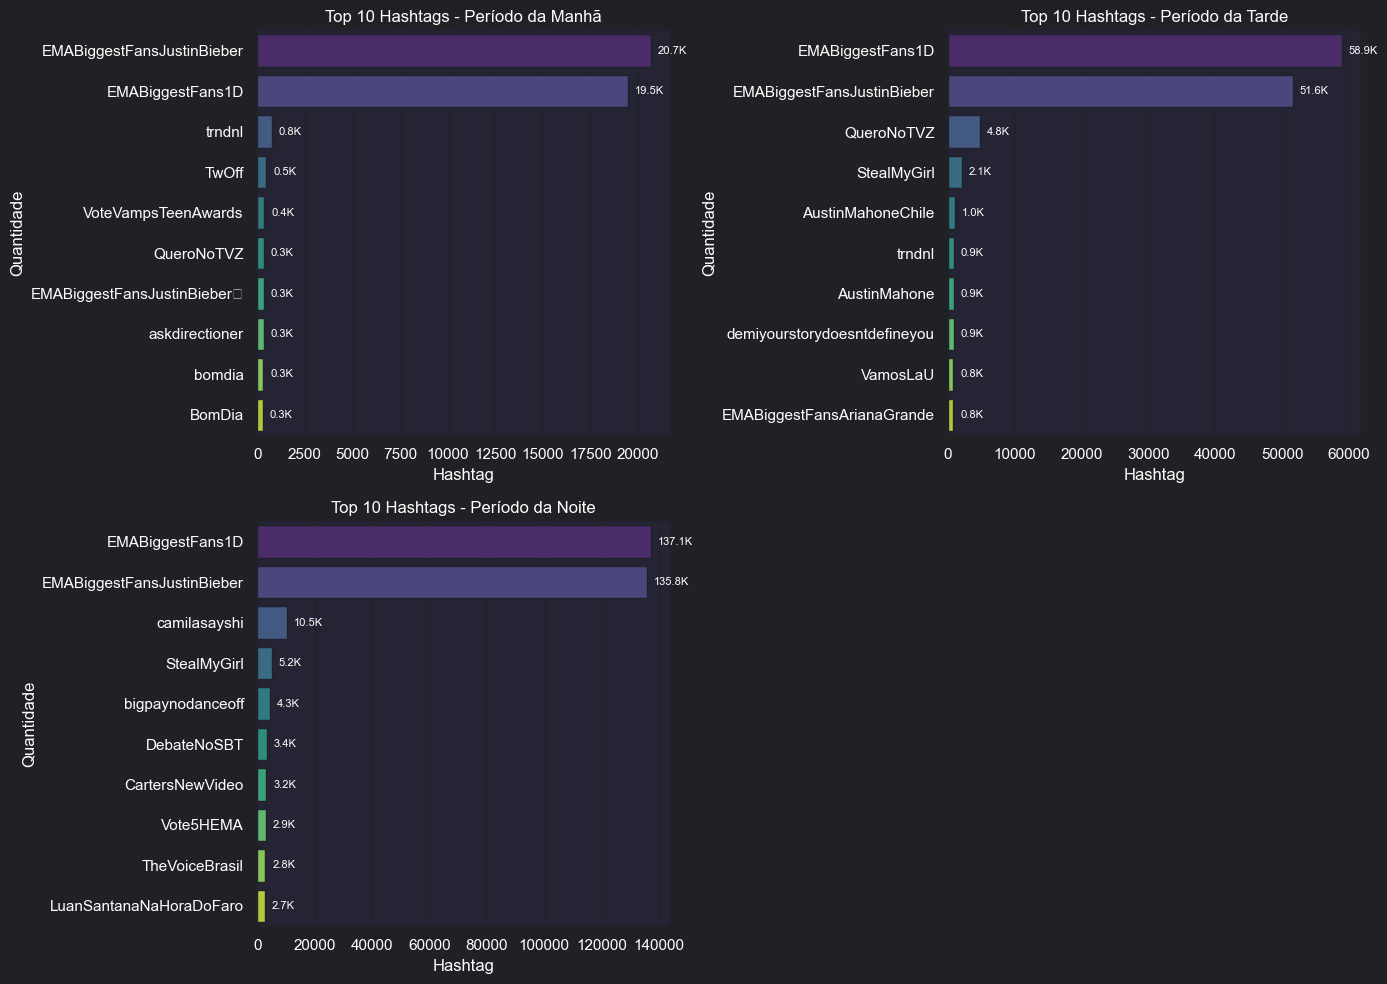

In [43]:
sns.set(style="darkgrid", rc={"axes.facecolor": "#252434", "figure.facecolor": "#202124", "axes.edgecolor": "#21212a", "grid.color": "#21212a"}) 

fig, axes = plt.subplots(2, 2, figsize=(14, 10), facecolor='#202124')

# Lista de dataframes e títulos
dataframes = [hashtags_morning_pandas, hashtags_afternoon_pandas, hashtags_night_pandas]
titles = ['Top 10 Hashtags - Período da Manhã', 'Top 10 Hashtags - Período da Tarde', 'Top 10 Hashtags - Período da Noite']

# Linearize a matriz de eixos para facilitar a iteração
axes = axes.flatten()

# Criar os gráficos de barras para cada subplot
for ax, data, title in zip(axes[:3], dataframes, titles):
    barplot = sns.barplot(ax=ax, x='count', y='hashtag', data=data, hue='hashtag', legend=False, palette='viridis', edgecolor="#21212a")
    
    for p in barplot.patches:
        width = p.get_width()
        height = p.get_height()
        barplot.annotate(format(width / 1000, '.1f') + "K",
                         (p.get_x() + width, p.get_y() + height / 2.),
                         ha='left', va='center',
                         xytext=(5, 0), textcoords='offset points',
                         fontsize=8, rotation=0, color='#ffffff')

    ax.set_xlabel('Hashtag', color='#ffffff')  
    ax.set_ylabel('Quantidade', color='#ffffff')  
    ax.set_title(title, color='#ffffff') 
    ax.tick_params(colors='#ffffff')
    ax.set_facecolor('#252434')

# Remover o eixo extra
axes[3].remove()

plt.tight_layout()

# Salvar o gráfico como PDF
plt.savefig('./outcome/Q1/top_hashtags_periodo.pdf', facecolor='#202124', bbox_inches='tight')
plt.show()
